**CNN time series classification, example 2, Delhi Climate data**

In [22]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# if your Jupyter kernel crashes during this code, use this setting
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [23]:
# load the datasets for combination
df1 = pd.read_csv("DailyDelhiClimateTrain.csv")
df2 = pd.read_csv("DailyDelhiClimateTest.csv")

# combine the datasets and reset the index
# so that we have the correct sequence number alongside the timestamp
df = pd.concat([df1, df2])
df = df.reset_index()

In [24]:
df.head()

,index,date,meantemp,humidity,wind_speed,meanpressure
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [25]:
df.describe()

,index,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000
mean,681.746193,25.221918,60.445229,6.899262,1010.593178
std,442.630431,7.345014,16.979994,4.510725,175.242704
min,0.000000,6.000000,13.428571,0.000000,-3.041667
25%,279.750000,18.500000,49.750000,3.700000,1001.875000
50%,673.500000,27.166667,62.440476,6.363571,1009.055556
75%,1067.250000,31.142857,72.125000,9.262500,1015.200000
max,1461.000000,38.714286,100.000000,42.220000,7679.333333


In [26]:
# this dataformat is not suitable yet for CNN time series classification
# because each point is separate in the dataset

# we have to process the data into smaller chunks => for examples
# chunks of 50 points at a time

# we are going to select meantemp and wind_speed as our target outputs
# in other words, we try to detect if any given signal is meantemp or wind_speed
df = df.drop(['humidity', 'meanpressure'], axis=1)

In [27]:
df.head()

,index,date,meantemp,wind_speed
0,0,2013-01-01,10.000000,0.000000
1,1,2013-01-02,7.400000,2.980000
2,2,2013-01-03,7.166667,4.633333
3,3,2013-01-04,8.666667,1.233333
4,4,2013-01-05,6.000000,3.700000


### Important in CNN => scale the values!

MinMaxScaler is enough

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# scale only relevant variables
num_cols = ['meantemp', 'wind_speed']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [29]:
# the data is starting simplify nicely
df.head()

,index,date,meantemp,wind_speed
0,0,2013-01-01,0.122271,0.000000
1,1,2013-01-02,0.042795,0.070583
2,2,2013-01-03,0.035662,0.109743
3,3,2013-01-04,0.081514,0.029212
4,4,2013-01-05,0.000000,0.087636


In [30]:
# let's use the sequence number instead of the time stamp
# starting from 1 until the final row
df['sequence'] = df.index + 1
df = df.drop(['date', 'index'], axis=1)

In [31]:
df.head()

,meantemp,wind_speed,sequence
0,0.122271,0.000000,1
1,0.042795,0.070583,2
2,0.035662,0.109743,3
3,0.081514,0.029212,4
4,0.000000,0.087636,5


In [32]:
df.tail()

,meantemp,wind_speed,sequence
1571,0.871179,0.131750,1572
1572,0.863537,0.164910,1573
1573,0.822271,0.210564,1574
1574,0.821507,0.235966,1575
1575,0.794760,0.287947,1576


**Split the DataFrame into timesteps**

**ALTERNATIVE 1: windowing (use only if you don't have much data)**

See CNN-materials for visualization on what windowing does...

In [33]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

# separate the output variables
meantemp = df['meantemp'].values
wind_speed = df['wind_speed'].values

# generate timestep windows for each signal
meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)
wind_speed_windows = sliding_window_view(wind_speed, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((meantemp_windows, wind_speed_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(meantemp_windows) + [1] * len(wind_speed_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (3054, 50)
y: (3054,)


**ALTERNATIVE 2: timesteps (use only if you have a lot of data)**

Also see CNN-materials in order to see how timesteps are different to windowing.

In [34]:
# from numpy.lib.stride_tricks import sliding_window_view

# timestep_size = 50

# # separate the output variables
# meantemp = df['meantemp'].values
# wind_speed = df['wind_speed'].values

# # generate timestep windows for each signal

# # for separate timesteps, add [::timestep_size] for each dataset (meantemp_windows, wind_speed_windows)
# # e.g. meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)[::timestep_size]
# # this filters every 50th (timestep_size) of a Python list
# # which results into a set of timesteps with no overlap! (in sequence)

# # RULE OF THUMB! If you have lots of data => use separate timesteps to avoid redundancy in data
# # If you lack data, use sliding window instead (to get more data, but also having redundancy introduced)
# # using separate time steps will also discard any extra data that doesn't fill the final timestep
# # in this case, there's 25 extra measurements in the end, and since timestep_size is 50, these 25 are discarded
# meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)[::timestep_size]
# wind_speed_windows = sliding_window_view(wind_speed, window_shape=timestep_size)[::timestep_size]

# # combine into X and y
# # use vstack to combine temperatures and wind speeds back together
# X = np.vstack((meantemp_windows, wind_speed_windows))

# # generate zeroes and ones for the output categories
# # 0 = meantemp
# # 1 = wind_speed
# y = np.array([0] * len(meantemp_windows) + [1] * len(wind_speed_windows))

# print("X:", X.shape)
# print("y:", y.shape)

**Shuffle the data**

In [35]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

**Visualize some test signals**

Change the signal index in order to see a different subsignal.

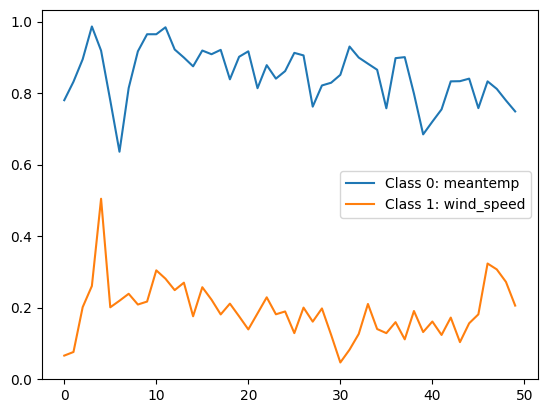

In [36]:
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: meantemp")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: wind_speed")
plt.legend()

**Finally we can do the train/test -split**

In [37]:
# define the cutoff point
# usually it's just easiest to do the splitting with a splitter index
# when it comes to CNN time series classification datasets
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [38]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

2137
917
2137
917


In [39]:
# convert the data into the required CNN -format
# usually the easiest approach is to modify
# your own dataset to follow the data format used by another example
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [40]:
# compare this to a known example
# where it works to check you have
# correct data format (e.g. FordA)
x_train

array([[[0.73362445],
        [0.6768559 ],
        [0.63755459],
        ...,
        [0.35534934],
        [0.33624454],
        [0.32478166]],

       [[0.82532751],
        [0.79475983],
        [0.77565502],
        ...,
        [0.7680131 ],
        [0.74672489],
        [0.77565502]],

       [[0.7802804 ],
        [0.83197266],
        [0.89469264],
        ...,
        [0.81195415],
        [0.77947598],
        [0.7489083 ]],

       ...,

       [[0.72925764],
        [0.7860262 ],
        [0.80349345],
        ...,
        [0.77947598],
        [0.83296943],
        [0.8202329 ]],

       [[0.50436681],
        [0.70815138],
        [0.54512373],
        ...,
        [0.81386463],
        [0.81768559],
        [0.82150655]],

       [[0.28511369],
        [0.35084083],
        [0.57614874],
        ...,
        [0.14803411],
        [0.4275225 ],
        [0.13707958]]], shape=(2137, 50, 1))

**Define a CNN- time series classification network for our data**

In [41]:
class_names = np.array(['meantemp', 'wind_speed'])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Jupyter kernel after this
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,802 (18.76 KB)

 Trainable params: 4,674 (18.26 KB)

 Non-trainable params: 128 (512.00 B)

**Train the model**

In [42]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2611 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.6369 - val_sparse_categorical_accuracy: 0.4790
Epoch 2/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.4790
Epoch 3/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1521 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.4790
Epoch 4/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.8779 - val_sparse_categorical_accuracy: 0.4790
Epoch 5/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.4790
Epoch 6/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.6590 - val_sparse_categorical_accuracy: 0.4930
Epoch 7/50

**Metrics and plots**

<Axes: >

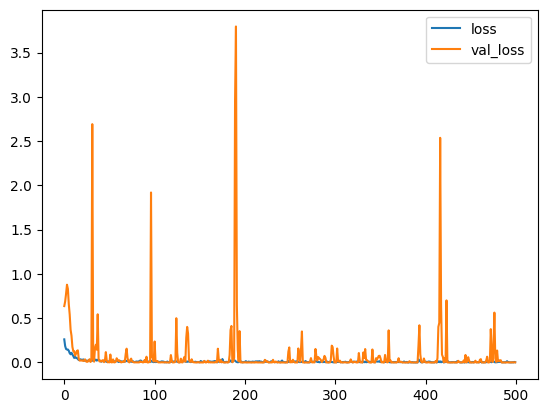

In [43]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

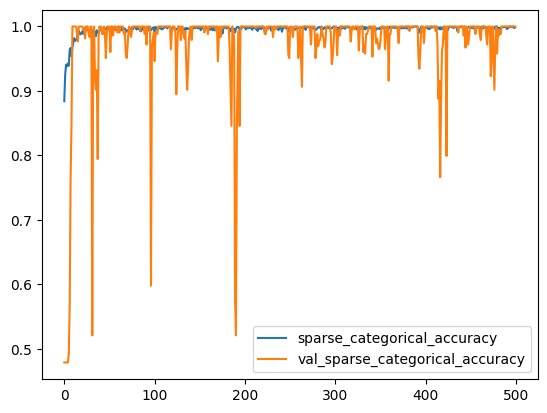

In [45]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [46]:
model = keras.models.load_model("best_model2.keras")

In [48]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.00023595297534484416, 1.0]

Train data evaluation:
[0.00013974252215120941, 1.0]


In [49]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

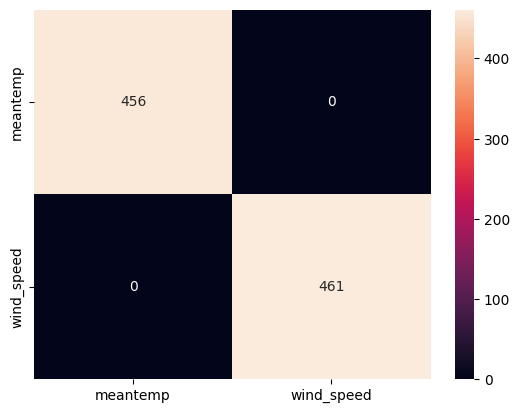

In [50]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names)

In [51]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=class_names))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))


              precision    recall  f1-score   support

    meantemp       1.00      1.00      1.00       456
  wind_speed       1.00      1.00      1.00       461

    accuracy                           1.00       917
   macro avg       1.00      1.00      1.00       917
weighted avg       1.00      1.00      1.00       917


Model overall accuracy: 100.00%


**Test the model with some imaginary/synthetic signal examples from your favorite Generative AI**

1
wind_speed


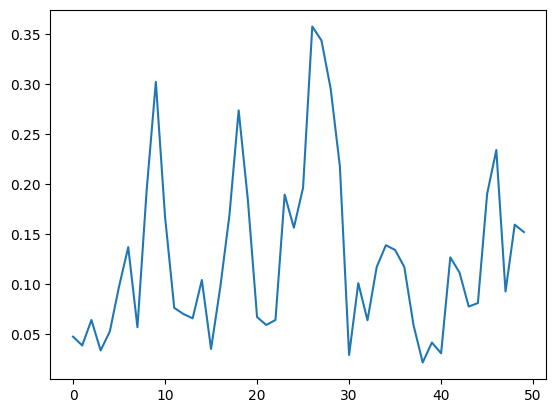

In [52]:
# example signal from test data
# WIND SPEED
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

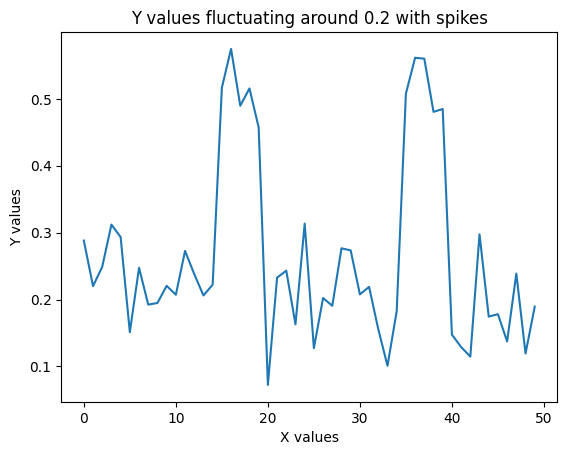

In [53]:
# IMAGINARY WIND SPEED SIGNAL
# THIS WAS ORIGINALLY ASKED FROM CHATGPT
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [54]:
# TRY OUR IMAGINARY WIND SIGNAL WITH THE MODEL

# wrap up the data points into the required NumPy-format
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

# create prediction
test_predict = model.predict(test_batch)
print(test_predict)

# get highest index and print name
index = np.argmax(test_predict)
print(class_names[index])

# it seems to predict the wind correctly also from an imaginary signal!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[6.761610e-07 9.999993e-01]]
wind_speed


0
meantemp


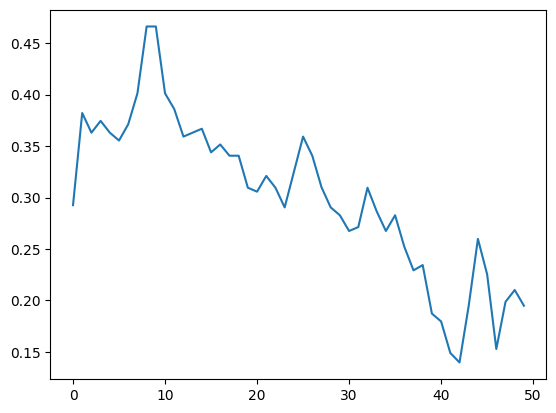

In [55]:
# example signal from test data
# MEAN TEMPERATURE
signal_index = 22
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

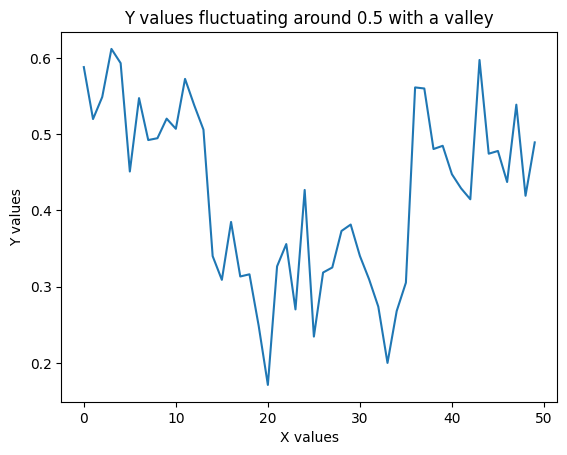

In [56]:
# IMAGINARY TEMPERATURE SIGNAL
# THIS WAS ORIGINALLY ASKED FROM CHATGPT

import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [57]:
# TRY OUR IMAGINARY MEAN TEMPERATURE SIGNAL WITH THE MODEL

# wrap up the data points into the required NumPy-format
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

# create prediction
test_predict = model.predict(test_batch)
print(test_predict)

# get highest index and name for this prediction
index = np.argmax(test_predict)
print(class_names[index])

# also seems to recognize the imaginary temperature signal correctly!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[9.9998355e-01 1.6449269e-05]]
meantemp
